In [1]:
%matplotlib inline
import glob
import os

import matplotlib.gridspec as mgrid
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns



import h5py
from umap import UMAP

from activ.clustering.viz import make_simdata_curves, make_dendrogram_scatterplots

 
from activ.clustering.viz import make_simdata_curves, plot_simdata_curvefit_results, plot_max1d_simdata_results,\
                                 make_clustered_plot, plot_real_foc_results, plot_real_accuracy_chance_results

from activ.readfile import TrackTBIFile

from activ.viz import remove_ticks

/Users/ajtritt/anaconda3/envs/activ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SIMDATA_SWEEP_RESULTS_PATH = 'simulation_data/dense/sweep_out/simdata.aggregated.h5'
TRACK_TBIFILE_PATH = '../tracktbi_files/tracktbi.scalar.h5'
EST_SIMDATA_SWEEP_RESULTS_PATH = 'simulation_data/dense/sweep_out/simdata.smooth.spread_asm.spread_foc.h5'
DEAD_CLUSTER_RESULTS = 'dead.ss90.u30_mean.iter250.h5'
NMF_TBIFILE_PATH = '../latent_features/NMF/tracktbi.reg_nmf.h5'
EST_SIMDATA_MAX_1D = 'simulation_data/dense/sweep_out/simdata.max1d.h5'

In [3]:
tbifile = TrackTBIFile(NMF_TBIFILE_PATH)

# from scipy.spatial.distance import pdist, squareform
# binary = list()
# continuous = list()
# for i in range(tbifile.outcomes.shape[1]):
#     # print(tbifile.outcome_features[i], np.unique(tbifile.outcomes[:, i]))
#     uniq = np.unique(tbifile.outcomes[:, i])
#     if len(uniq) == 2:
#         binary.append(i)
#     else:
#         continuous.append(i)

# bindist = pdist(tbifile.outcomes[:, binary], metric='jaccard')
# contdist = pdist(tbifile.outcomes[:, continuous], metric='euclidean')

# finaldist = (len(binary)*bindist/bindist.max() + len(continuous)*contdist/contdist.max())/tbifile.outcomes.shape[1]
# finaldist = squareform(finaldist)

# emb = UMAP(n_components=2, min_dist=0.5, random_state=20004, metric='precomputed').fit_transform(finaldist)

# emb = UMAP(n_components=2, min_dist=0, random_state=20001).fit_transform(tbifile.outcomes)
emb = tbifile.outcome_emb
oc_weights = tbifile.nmf.oc
oc_colors = tbifile.outcome_colors

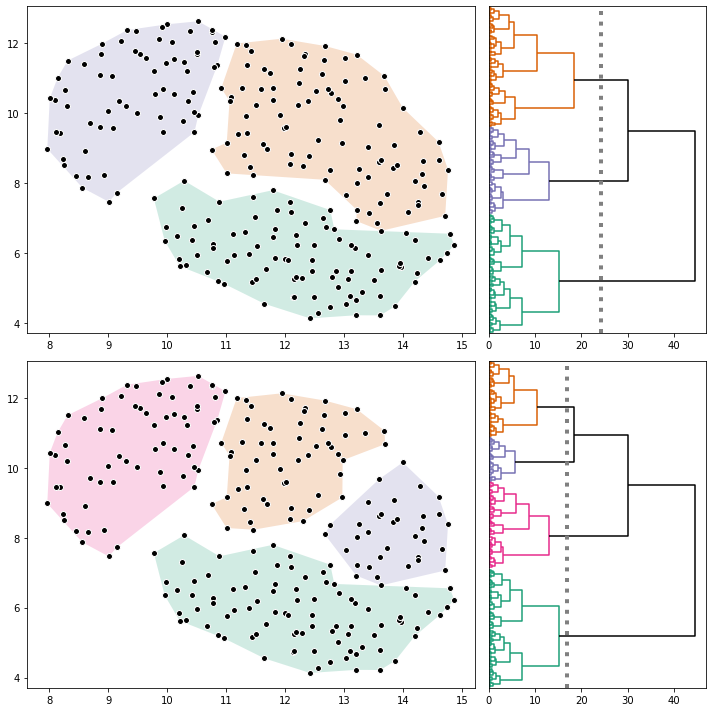

In [4]:
fig = plt.figure(figsize=(10, 10))
gs = mgrid.GridSpec(4,3)
axes = np.zeros((2, 2), dtype=object)

axes[0, 0] = fig.add_subplot(gs[0:2, 0:2])
axes[1, 0] = fig.add_subplot(gs[2:4, 0:2])

axes[0, 1] = fig.add_subplot(gs[0:2, 2])
axes[1, 1] = fig.add_subplot(gs[2:4, 2])

make_dendrogram_scatterplots(emb, axes=axes, cmap='Dark2', convex=False, method='complete')
plt.tight_layout()

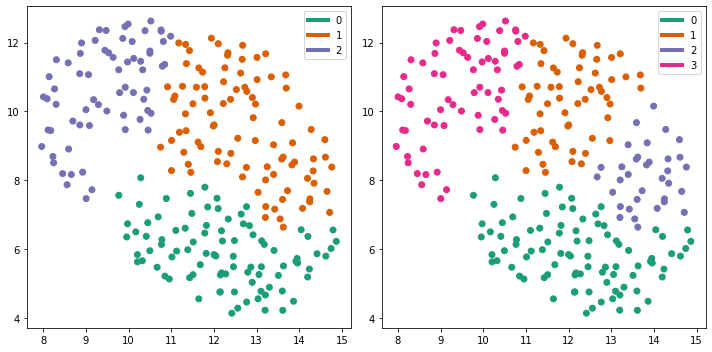

In [5]:
from scipy.cluster.hierarchy import cut_tree, dendrogram, linkage
from scipy.spatial.distance import pdist

from matplotlib.lines import Line2D
dist = pdist(emb)
Z = linkage(dist, method='ward')
labels = cut_tree(Z, n_clusters=[3, 4])

pal = sns.color_palette('Dark2', 10).as_hex()
#pal = [pal[i] for i in (3,1,0,2)]

colors = np.zeros((len(emb), 2), dtype='U7')
colors[labels[:,0] == 0, 0] = pal[0]
colors[labels[:,0] == 1, 0] = pal[1]
colors[labels[:,0] == 2, 0] = pal[2]

orig_labels = labels[:,1].copy()
labels[orig_labels==2, 1] = 3
labels[orig_labels==3, 1] = 2

colors[labels[:,1] == 0, 1] = pal[0]
colors[labels[:,1] == 1, 1] = pal[1]
colors[labels[:,1] == 2, 1] = pal[2]
colors[labels[:,1] == 3, 1] = pal[3]



fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(emb[:, 0], emb[:, 1], c=colors[:, 0])
axes[1].scatter(emb[:, 0], emb[:, 1], c=colors[:, 1])
axes[0].legend([Line2D([0], [0], color=p, lw=4) for p in pal[:3]], [0, 1, 2])
axes[1].legend([Line2D([0], [0], color=p, lw=4) for p in pal], [0, 1, 2, 3])
plt.tight_layout()
plt.savefig('../paper/umap_scatter_3-4.png', dpi=200)

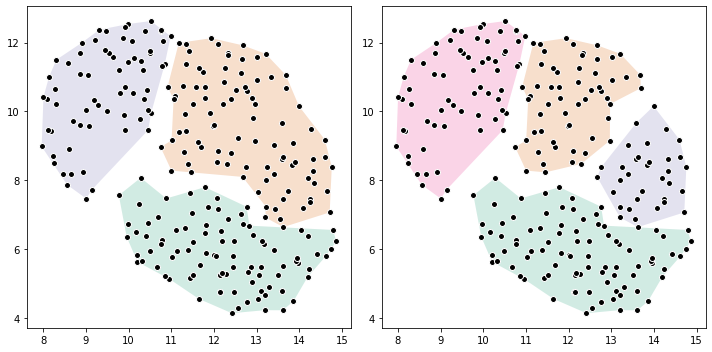

In [6]:
from concavity.core import concave_hull, plot_concave_hull
import geopandas as gpd

def shade_around(data, convex_hull=True, ax=None, stretch=0.05, alpha=0.2, color='blue'):
    """
    Draw a triangulated patch around a set of data points

    Args:
        data (np.array)         : the points to draw around
        ax (plt.Axes)           : the Axes to draw on
        stretch (float)         : the amount to stetch the triangle vertices
                                  from the center of the points
        alpha (float)           : the transparency of the patch
        color (str or tuple)    : the color of the patch

    """

    
    ax = ax or plt.gca
    ch = concave_hull(data, 16)
    gpd.GeoSeries([ch]).plot(ax=ax, alpha=alpha, color=color, edgecolor='none')

def cluster_results_plot(emb, colors, ax=None, shade_stretch=None):
    """
    Plot 2-D UMAP embedding with colors

    Args:
        emb (np.array)          : 2-D UMAP embedding
        colors (np.array)       : array of colors for each point
    """
    ax = ax or plt.gca()
    shade_stretch = None or 0.12
    for color in np.unique(colors):
        mask = colors == color
        shade_around(emb[mask], ax=ax, color=color, stretch=shade_stretch)
    ax.scatter(emb[:,0], emb[:,1], c='k', edgecolors='w')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cluster_results_plot(emb, colors[:,0], ax=axes[0], shade_stretch=0.00)
cluster_results_plot(emb, colors[:,1], ax=axes[1], shade_stretch=0.00)
ret = axes[0].axis('auto')
ret = axes[1].axis('auto')
plt.tight_layout()
plt.savefig('../paper/clusters_concave_hull.png', dpi=200)

simulation_data/dense/sweep_out/simdata.aggregated.h5


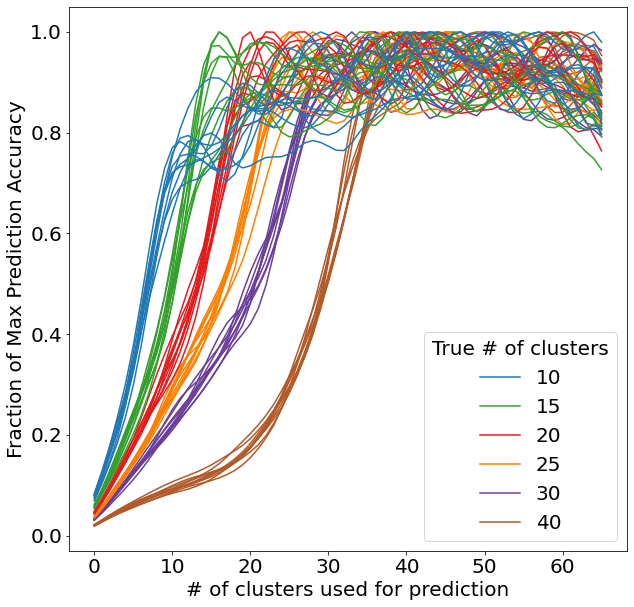

In [7]:
plt.figure(figsize=(10,10))
print(SIMDATA_SWEEP_RESULTS_PATH)
make_simdata_curves(path=SIMDATA_SWEEP_RESULTS_PATH, ax=plt.gca(), fontsize=20)

In [8]:
from activ.clustering.summarize import flatten, summarize_flattened
import matplotlib.lines as mlines

def make_chance_simdata_curves(ax=None, path=None, keep_true_nocs=[10, 15, 20, 25, 30, 40], fontsize='x-large'):
    """
    Plot fold-over-chance (FOC) for simulation data.  Plot lines for simulations that used
    a true number-of-clusters (NOC) in *keep_true_nocs*

    Y-axis is normalized to be between (0, L), where L is the max FOC for that simulated model

    Args:
        path (str)              : the path to the aggregated simulation results file
        ax (plt.Axes)           : the Axes object to use for plot
        keep_true_nocs (bool)   : the number-of-clusters of the simulated models to plot
    """
    ax = ax or plt.gca()
    keep_true_nocs = np.array(keep_true_nocs)
    with h5py.File(path, 'r') as f:
        foc = f['foc'][:]
        acc = f['accuracy'][:]
        cha = f['chance'][:]
        nocs = f['noc'][:]
        mask = np.isin(nocs, keep_true_nocs)
        foc = foc[mask]
        acc = acc[mask]
        cha = cha[mask]
        nocs = nocs[mask]

        if 'tested_noc' in f:
            tested_nocs = f['tested_noc'][:]
        else:
            tested_nocs = np.arange(2,51)
    true_nocs = np.sort(np.unique(nocs))[::-1]
    X_acc = np.zeros((acc.shape[0], acc.shape[1]))
    X_cha = np.zeros((cha.shape[0], cha.shape[1]))
    y = np.zeros(acc.shape[0], dtype=int)
    X_i = 0

    for j, true_noc in enumerate(true_nocs):
        idx = nocs == true_noc
        n = np.sum(idx)
        _noc = nocs[idx]
        _acc = acc[idx]
        _cha = cha[idx]
        for i in range(_acc.shape[0]):
            noc_flat, acc_flat = flatten(tested_nocs, _acc[i], filter_inf=False, smooth=True)
            noc_flat, cha_flat = flatten(tested_nocs, _cha[i], filter_inf=False, smooth=True)

            _x, _lower, _med, _upper = summarize_flattened(noc_flat, acc_flat, iqr=False)
            _med /= np.max(_med)
            X_acc[X_i] = _med

            _x, _lower, _med, _upper = summarize_flattened(noc_flat, cha_flat, iqr=False)
            X_cha[X_i] = _med
            y[X_i] = true_noc

            X_i += 1
    pal = sns.color_palette('Paired', len(keep_true_nocs)*2)[1::2]
    colors = dict(zip(keep_true_nocs, pal))

    tmpX = X_acc[:, :-3]
    for i in np.unique(y)[::-1]:
        mask = y == i
        ax.plot(tmpX[mask].T, c=colors[i], label=i)

    tmpX = X_cha[:, :-3]
    for i in np.unique(y)[::-1]:
        mask = y == i
        ax.plot(tmpX[mask].T, c=colors[i], label=i, ls='--')
        
    handles = list()
    labels = list()
    for noc, col in colors.items():
        handles.append(mlines.Line2D([0], [0], color=col))
        labels.append(str(noc))

    ax.tick_params('both', labelsize=fontsize)
    ax.set_xlabel('# of clusters used for prediction', fontsize=fontsize)
    ax.set_ylabel("Fraction of Max Prediction Accuracy", fontsize=fontsize)
    ax.legend(handles, labels, title='True # of clusters', fontsize=fontsize, title_fontsize=fontsize, loc='lower right')

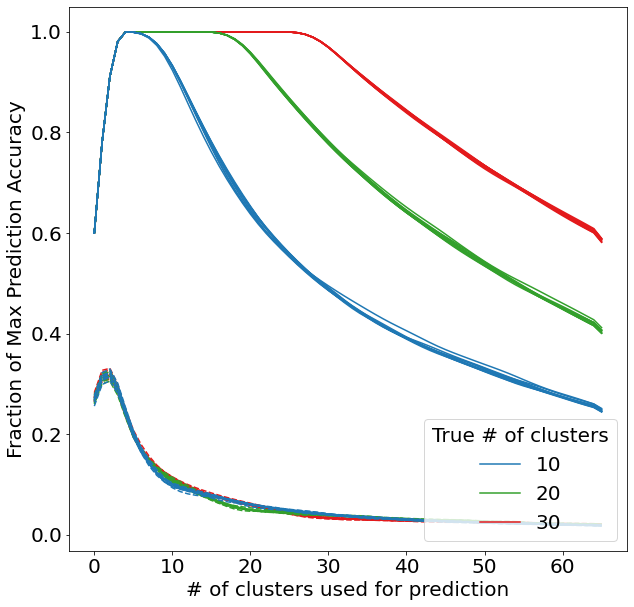

In [9]:
plt.figure(figsize=(10,10))
make_chance_simdata_curves(path=SIMDATA_SWEEP_RESULTS_PATH, ax=plt.gca(), fontsize=20, keep_true_nocs=[10, 20, 30])
plt.savefig('../paper/clustering_sim_acc_chance.png', dpi=100)

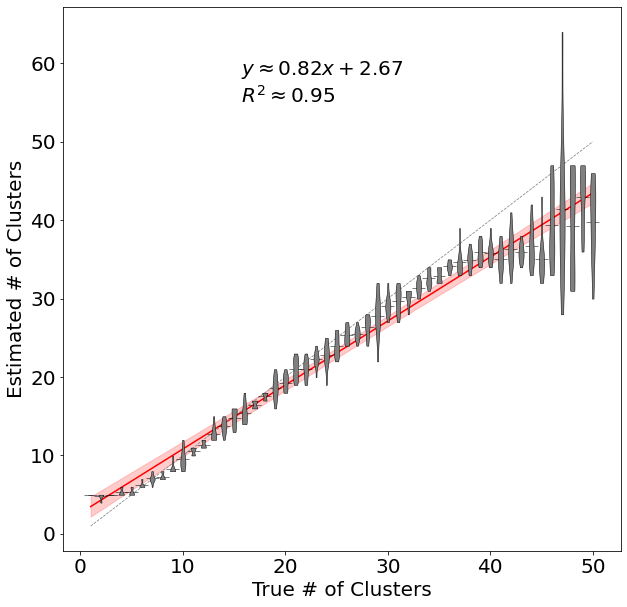

In [10]:
plt.figure(figsize=(10, 10))
plot_max1d_simdata_results(EST_SIMDATA_MAX_1D, fontsize=20)

LinearRegression()

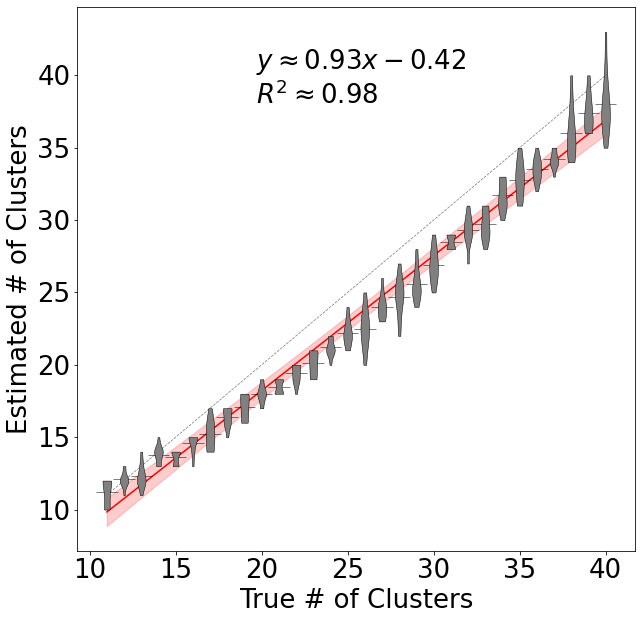

In [11]:
plt.figure(figsize=(10, 10))
plot_simdata_curvefit_results(EST_SIMDATA_SWEEP_RESULTS_PATH, fontsize=26)

(7.588095331192017, 15.248142576217651)
(3.6860301971435545, 13.091176223754882)


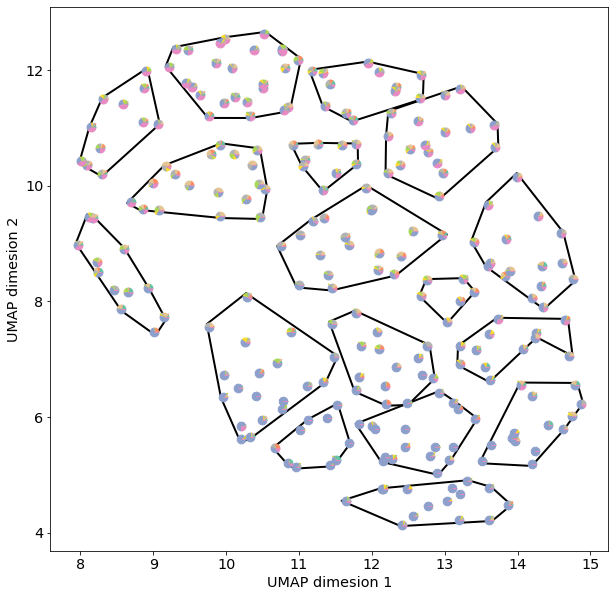

In [12]:
plt.figure(figsize=(10, 10))
all_colors = sns.color_palette('tab20b', 20).as_hex() + sns.color_palette('tab20c', 20).as_hex()
all_colors = all_colors[0::4] + all_colors[1::4] + all_colors[2::4]
all_colors = all_colors[:17]
ax = plt.gca()

make_clustered_plot(emb, 17, oc_colors, weights=oc_weights, ax=ax, stretch=0.05, ca_kwargs=dict(linewidth=2, alpha=1.0), s=80)
#plt.tight_layout()
print(ax.get_xlim())
print(ax.get_ylim())
plt.savefig('../paper/outcome_scatter_piechart.png', dpi=200)

(7.588095331192017, 15.248142576217651)
(3.6860301971435545, 13.091176223754882)


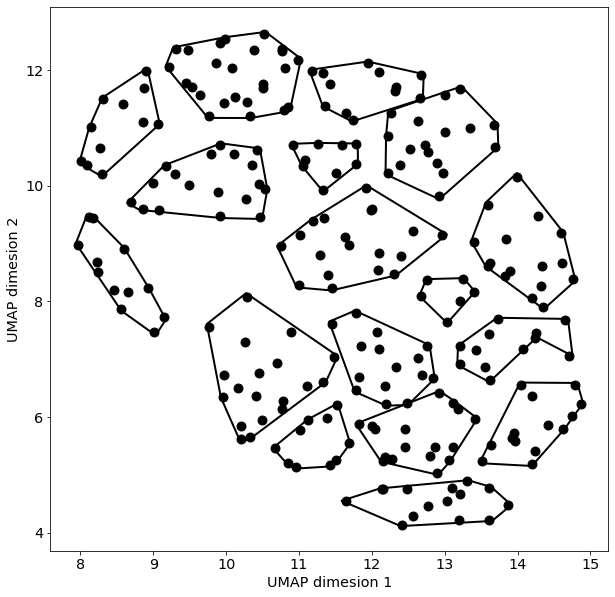

In [13]:
plt.figure(figsize=(10, 10))
all_colors = sns.color_palette('tab20b', 20).as_hex() + sns.color_palette('tab20c', 20).as_hex()
all_colors = all_colors[0::4] + all_colors[1::4] + all_colors[2::4]
all_colors = all_colors[:17]
ax = plt.gca()
ax.tick_params('both', labelsize=20)
make_clustered_plot(emb, 17, oc_colors, ax=ax, stretch=0.05, ca_kwargs=dict(linewidth=2, alpha=1.0), s=80)
#plt.tight_layout()
print(ax.get_xlim())
print(ax.get_ylim())
plt.savefig('../paper/outcome_scatter_solid.png', dpi=200)

(7.588095331192017, 15.248142576217651)
(3.6860301971435545, 13.091176223754882)


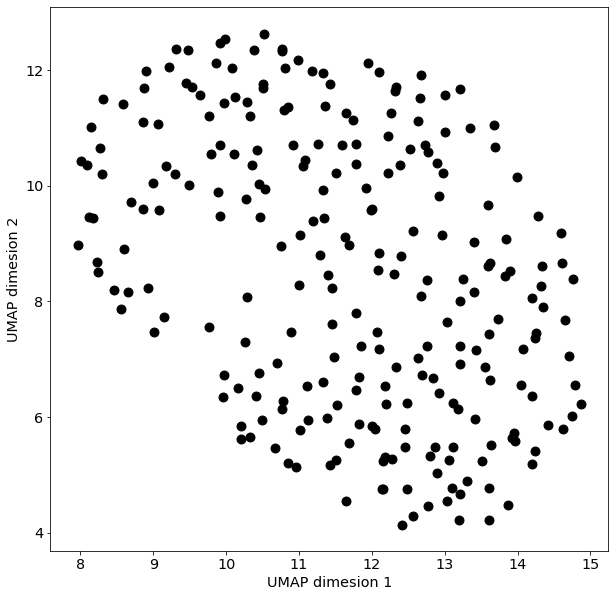

In [14]:
plt.figure(figsize=(10, 10))
all_colors = sns.color_palette('tab20b', 20).as_hex() + sns.color_palette('tab20c', 20).as_hex()
all_colors = all_colors[0::4] + all_colors[1::4] + all_colors[2::4]
all_colors = all_colors[:17]
ax = plt.gca()
ax.tick_params('both', labelsize=20)
make_clustered_plot(emb, 17, oc_colors, ax=ax, stretch=0.05, ca_kwargs=dict(linewidth=0.0, alpha=1.0), s=80)
#plt.tight_layout()
print(ax.get_xlim())
print(ax.get_ylim())
plt.savefig('../paper/outcome_scatter_solid_noclusters.png', dpi=200)

19

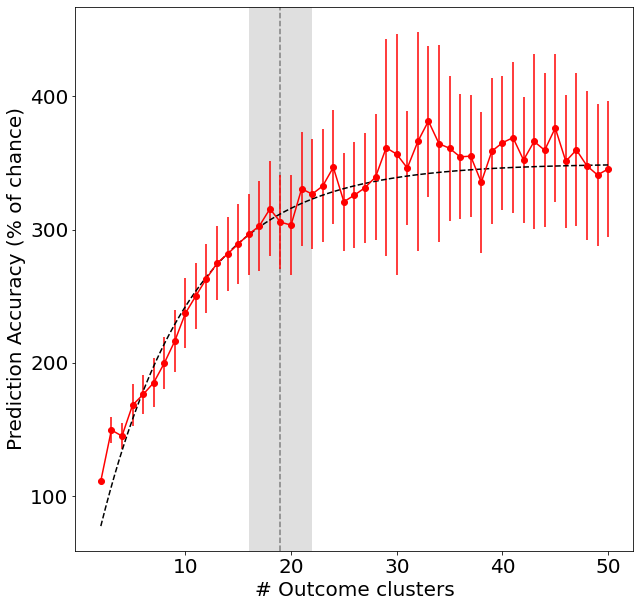

In [15]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.tick_params('both', labelsize=20)
plot_real_foc_results(DEAD_CLUSTER_RESULTS, simdata_results_path=EST_SIMDATA_SWEEP_RESULTS_PATH, fontsize=20, ax=ax)

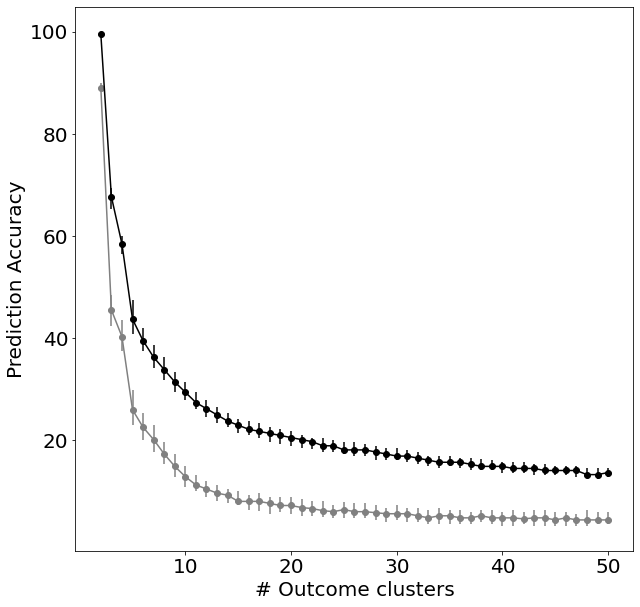

In [16]:
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.tick_params('both', labelsize=20)
plot_real_accuracy_chance_results(DEAD_CLUSTER_RESULTS, fontsize=20, ax=ax)

estimate: 19


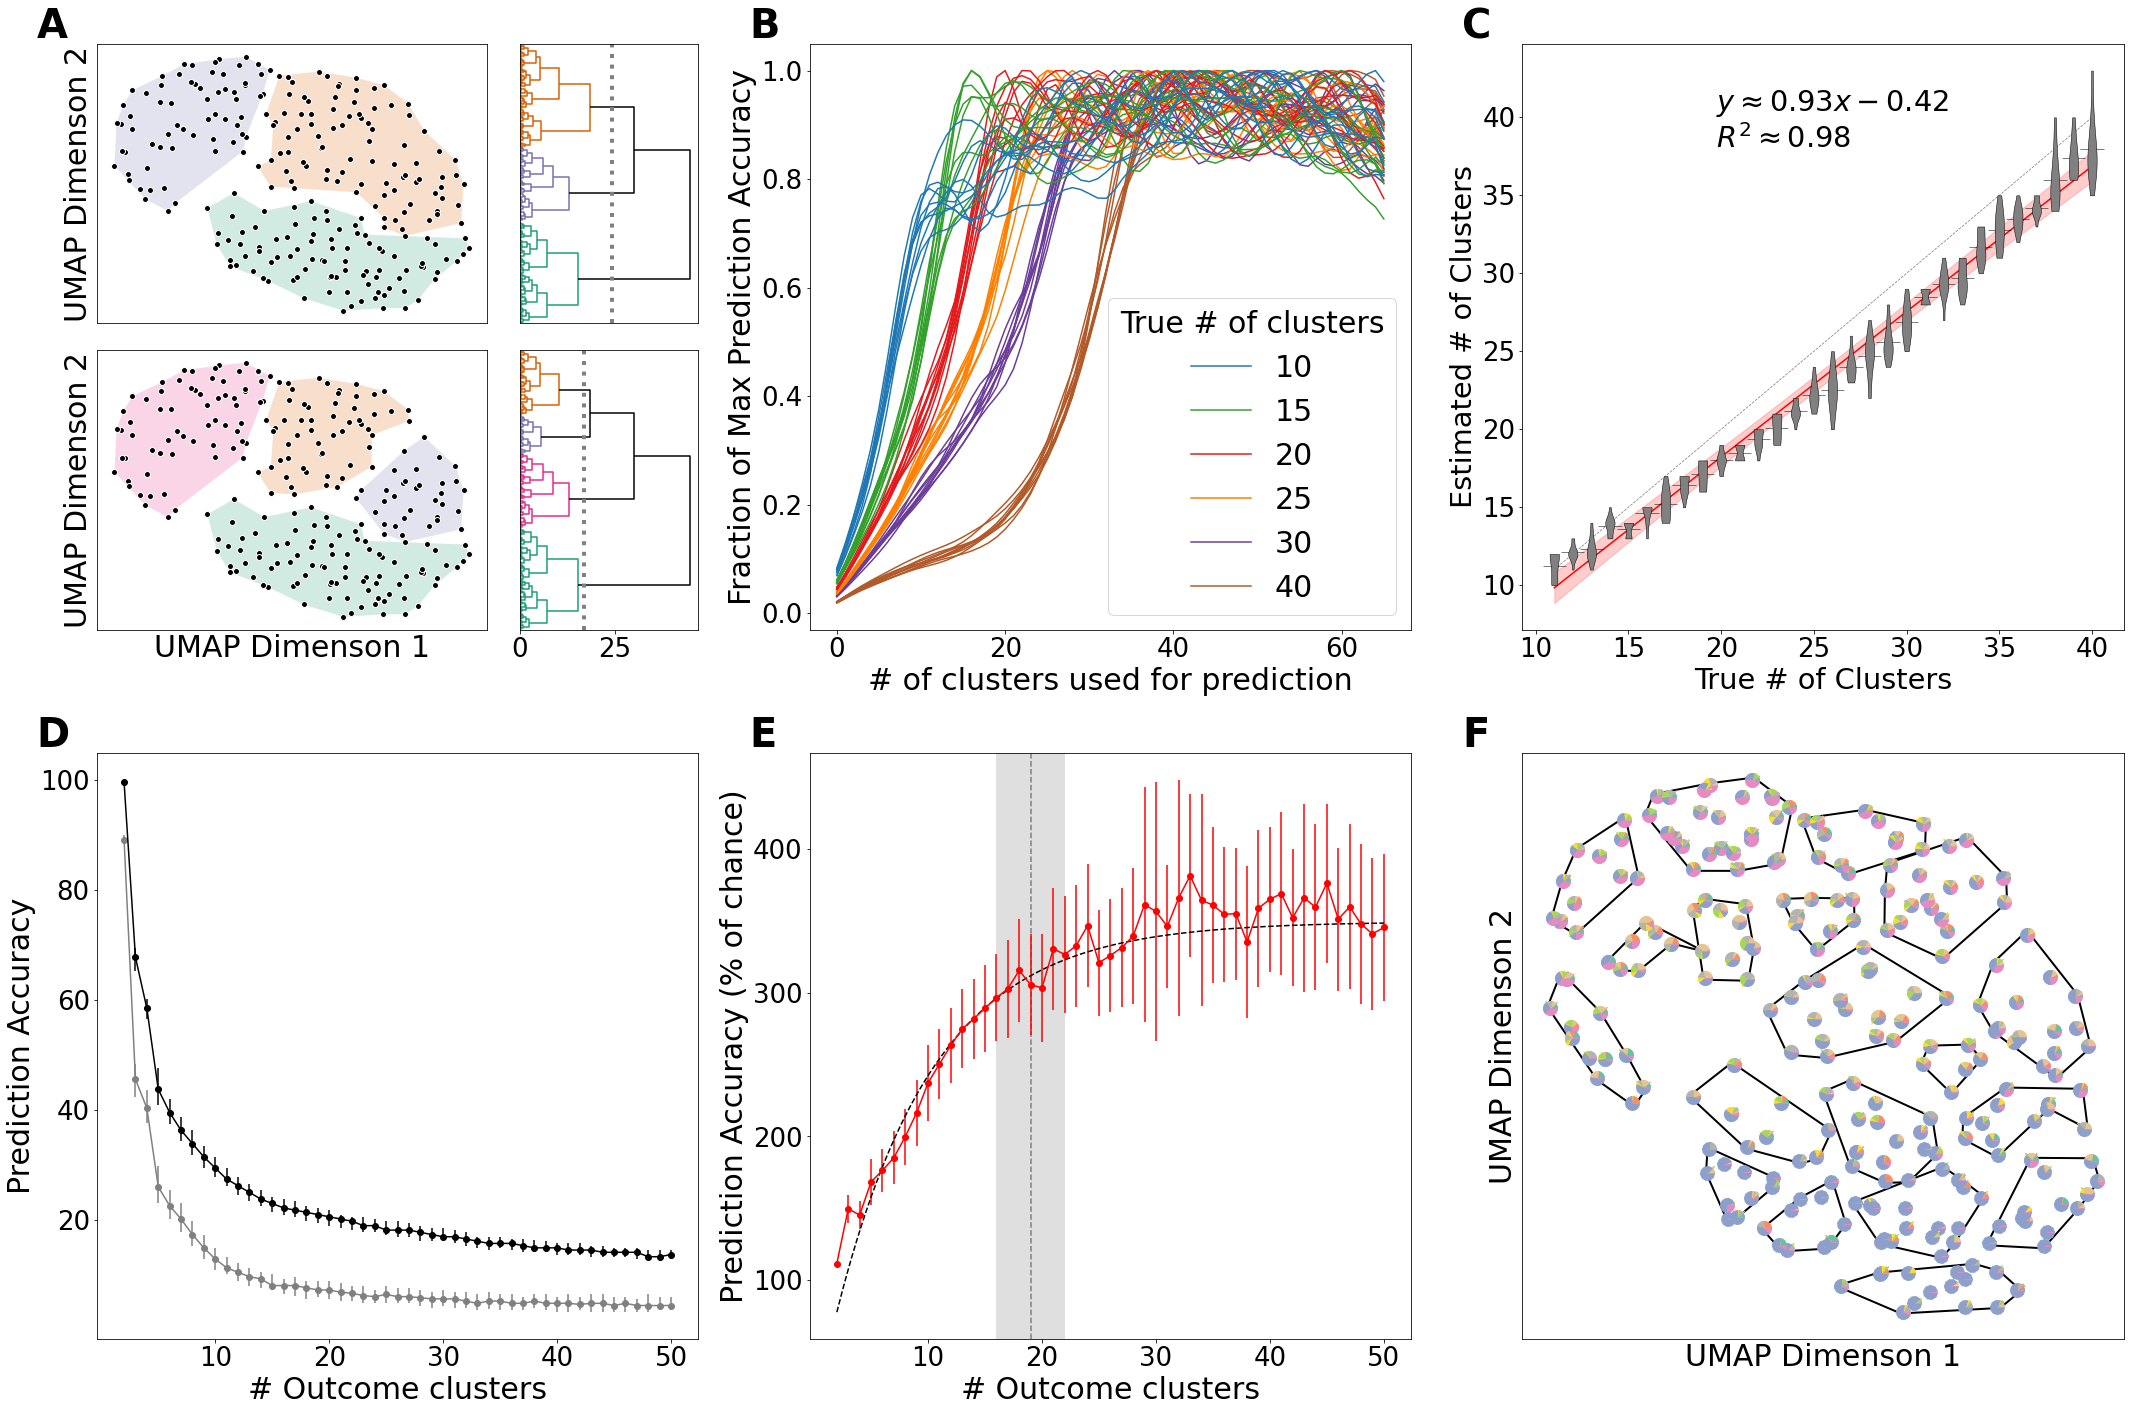

In [28]:
####
# - reorder upper right figure so 30 -25 - 20 - 15 - 10 - 5 is drawn first
# - color by dominant NMFs, and draw circles that correspond to clusters
# - UMAP scatter plot axes need numbers
# - for lower left, try violins and scattered points (black points)
#   - fit regression (red) and put CI around (pink)
#   - unity can be dotted gray line
#   - put R2 in left corner
# - bottom right - add curve fit

size1 = 26
size2 = 30
size3 = 40


def add_label(ax, label):
    ax.text(-0.1, 1.01, label, transform=ax.transAxes, weight='bold', size=size3)    

fig = plt.figure(figsize=(30, 20))
# mpl.rcParams['font.size'] = round(0.1 * fig.get_figwidth() * fig.get_figheight())
mpl.rcParams['font.size'] = 20
gsMain = mgrid.GridSpec(2, 3)

axA = fig.add_subplot(gsMain[0, 0])
add_label(axA, 'A')
axA.axis('off')

gsA = mgrid.GridSpecFromSubplotSpec(4,3, subplot_spec=gsMain[0, 0])

axes = np.zeros((2, 2), dtype=object)
axes[0, 0] = fig.add_subplot(gsA[0:2, 0:2])

axes[1, 0] = fig.add_subplot(gsA[2:4, 0:2])

## keep this, seems like something Kris will want
axes[0, 0].get_shared_x_axes().join(axes[0,0], axes[1,0])
axes[0, 0].set_xticklabels([])
axes[0, 0].set_xticks([])

axes[0, 1] = fig.add_subplot(gsA[0:2, 2])
axes[1, 1] = fig.add_subplot(gsA[2:4, 2])
## keep this, seems like something Kris will want
axes[0, 1].get_shared_x_axes().join(axes[0,1], axes[1,1]) # this does not work
axes[0, 1].set_xticklabels([])
axes[0, 1].set_xticks([])


# UMAP plots with possible ways to cut tree
make_dendrogram_scatterplots(emb, axes=axes, cmap='Dark2', convex=False)

remove_ticks(axes[0,0])
remove_ticks(axes[1,0])
axes[0,0].set_ylabel("UMAP Dimenson 2", fontsize=size2)
axes[1,0].set_ylabel("UMAP Dimenson 2", fontsize=size2)
axes[1,0].set_xlabel("UMAP Dimenson 1", fontsize=size2)


# fold over chance for a some simulation scenarios
axB = fig.add_subplot(gsMain[0, 1])
make_simdata_curves(path=SIMDATA_SWEEP_RESULTS_PATH, ax=axB, fontsize=size2)
add_label(axB, 'B')

# dense sweep results
axC = fig.add_subplot(gsMain[0, 2])
# plot_simdata_results(EST_SIMDATA_MAX_1D, ax=axC)
plot_simdata_curvefit_results(EST_SIMDATA_SWEEP_RESULTS_PATH, ax=axC)
add_label(axC, 'C')

# accuracy and chance
axD = fig.add_subplot(gsMain[1, 0])
plot_real_accuracy_chance_results(DEAD_CLUSTER_RESULTS, ax=axD, fontsize=size2)
add_label(axD, 'D')

# fold over chance
axE = fig.add_subplot(gsMain[1, 1])
est = plot_real_foc_results(DEAD_CLUSTER_RESULTS, ax=axE, fontsize=size2, 
                            simdata_results_path=EST_SIMDATA_SWEEP_RESULTS_PATH)
print('estimate:', est)
add_label(axE, 'E')


# number of clusters 
axF = fig.add_subplot(gsMain[1, 2])
#make_clustered_plot(emb, est, oc_weights, oc_colors, ax=axF, cmap='tab20', s=80)
make_clustered_plot(emb, est, oc_colors, weights=oc_weights, ax=axF, stretch=0.05, ca_kwargs=dict(linewidth=2, alpha=1.0), s=200)
axF.set_xlabel("UMAP Dimenson 1", fontsize=size2)
axF.set_ylabel("UMAP Dimenson 2", fontsize=size2)
add_label(axF, 'F')
axF.set_xlim(axes[0,0].get_xlim())
axF.set_ylim(axes[0,0].get_ylim())


for ax in axes.ravel():
    ax.tick_params('both', labelsize=size1)

for ax in (axA, axB, axC, axD, axE):
    ax.tick_params('both', labelsize=size1)

remove_ticks(axF)

plt.tight_layout()
plt.savefig('../paper/MultiPanel_clustering.png', dpi=200)